## TEM image analysis
___

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.filters import threshold_adaptive, threshold_otsu
from skimage.color import rgb2gray, label2rgb
from skimage import data,io,filters,measure,img_as_ubyte, segmentation, morphology
import skimage
from skimage.feature import peak_local_max
import scipy.ndimage as ndi

%matplotlib inline

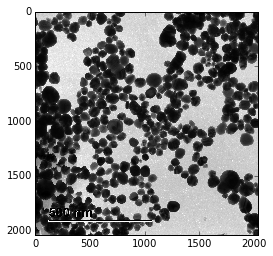

In [5]:
origfull = io.imread('../AgNP-12.tif')
orig = origfull[4:-4,4:-4]
imggray = rgb2gray(orig)
fig = plt.figure()
plt.gray()
plt.imshow(imggray)

Otsu threshold: 130


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


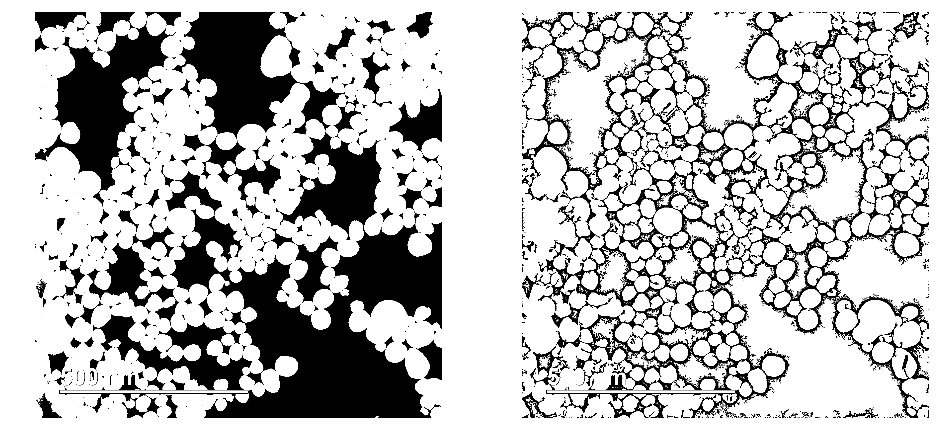

In [49]:
imginv = np.copy(imggray)
imginv = np.invert(img_as_ubyte(imginv))

otsu = threshold_otsu(imginv)
imgotsu = imginv > otsu

BlockSize = 41
imgadpt = threshold_adaptive(imginv,BlockSize,offset=0)
imgfill = ndi.binary_fill_holes(imgadpt)

print("Otsu threshold:", otsu)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.axis('off')
ax1.imshow(imgotsu)
ax2.axis('off')
ax2.imshow(imgfill)

In [69]:
image = np.copy(imgotsu)
# image = np.copy(imgfill)

distance = ndi.distance_transform_edt(image)
localmaxi = peak_local_max(distance, indices=False, footprint=np.ones((51,51)), labels=image)
markers = measure.label(localmaxi)

labels = morphology.watershed(-distance, markers, mask=image)
labels = morphology.closing(labels)

print('Number of labels:',labels.max())

Number of labels: 364


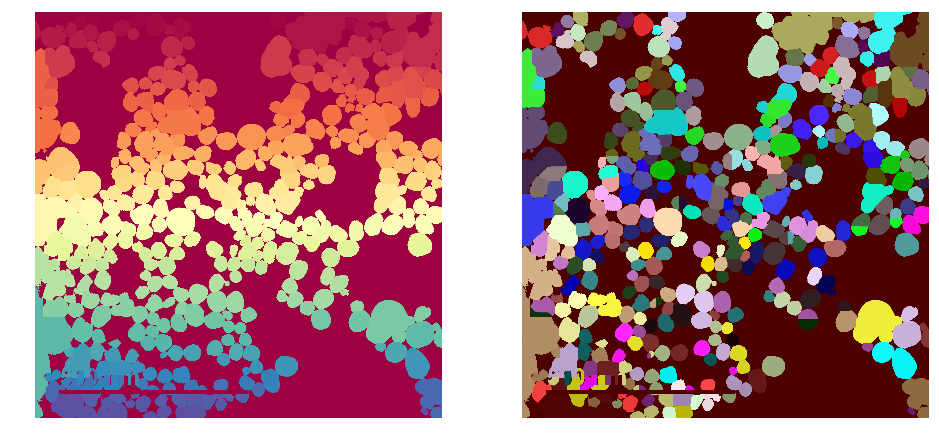

In [70]:
# imglbl, numlbls = measure.label(labels, connectivity=1, return_num=True)
# imgoverlay = label2rgb(imglbl, image=imglbl.astype(float))
imgoverlay = label2rgb(labels, image=labels.astype(float))

# print("Number of regions:", labels)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.axis('off')
ax1.imshow(labels, cmap='Spectral')
ax2.axis('off')
ax2.imshow(imgoverlay)

In [72]:
regions = measure.regionprops(labels)

# Find labels with desired properties

ecc = []
area = []
solid = []
ext = []
perim = []
ediam = []
majax = []
minax = []
for i in range(len(regions)):
    ecc.append(regions[i].eccentricity)
    area.append(regions[i].area)
    perim.append(regions[i].perimeter)
    ediam.append(regions[i].equivalent_diameter)
    majax.append(regions[i].major_axis_length)
    minax.append(regions[i].minor_axis_length)
    ext.append(regions[i].extent)
    
#    solid.append(regions[i].solidity)
#    extent.append(regions[i].extent)

In [73]:
ecirc = np.pi*np.array(ediam)
ds = list(zip(ecc, area, perim, ecirc.tolist(), minax, majax, ext))
cols = ['Ecc','Area','Perimeter', 'EquivCircleCircum', 'MinorAxis', 'MajorAxis', 'Extent']
df = pd.DataFrame(ds, columns=cols)

Identified NPs: 364
0.416790681367 0.861489857


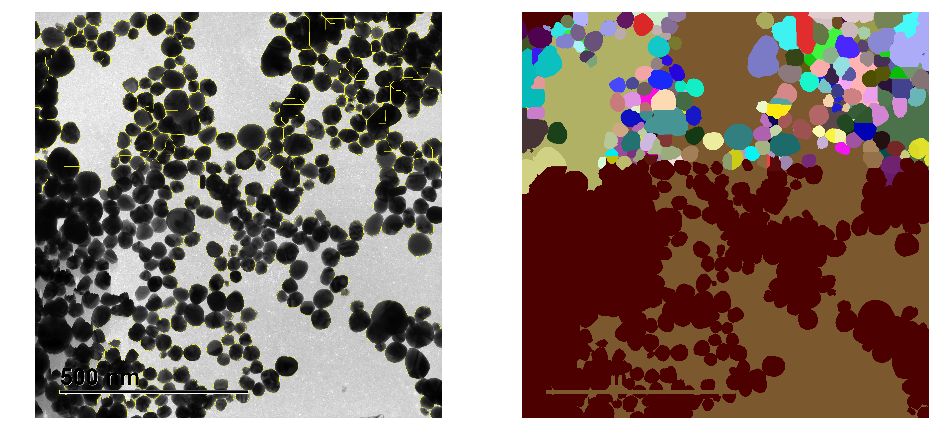

In [76]:
atest = df.Perimeter/df.EquivCircleCircum
# nps = df[(df.Ecc<0.5) & (df.Area>1000) & (df.MinorAxis/df.MajorAxis>0.92) & (atest<1.5) & (df.Extent>0.8)]
nps = df

print("Identified NPs:", len(nps))
print(min(ext), max(ext))

# Select the labels found above
# imglbl = skimage.segmentation.clear_border(imglbl)
mask = np.in1d(imglbl.flatten(),nps.index)
select = imglbl*mask.reshape(imglbl.shape)
# set(select.flatten().tolist())

# Plot the labels found above

imgselect = label2rgb(select, image=select.astype(float))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.axis('off')
ax1.imshow(skimage.segmentation.mark_boundaries(imggray.astype(float), select))
ax2.axis('off')
ax2.imshow(imgselect)

In [75]:
nps

,Ecc,Area,Perimeter,EquivCircleCircum,MinorAxis,MajorAxis,Extent
0,0.798455,4245,264.894444,230.963727,57.876772,96.132072,0.792273
1,0.552924,5066,304.214249,252.311778,74.085452,88.913377,0.791686
2,0.445487,5914,294.634560,272.612391,82.236896,91.855220,0.730214
3,0.391182,5869,294.977705,271.573248,83.010624,90.198221,0.775810
4,0.352602,3360,231.001046,205.482372,63.355506,67.703910,0.759837
5,0.540376,2711,204.267027,184.573646,54.206543,64.422414,0.784433
6,0.450485,8682,358.232539,330.304753,99.812763,111.799443,0.726649
7,0.652116,6935,361.931024,295.208029,84.864120,111.940304,0.621416
8,0.529242,5523,327.676190,263.446512,77.432791,91.261555,0.764853
9,0.445494,2049,192.994949,160.463371,49.080126,54.820669,0.758889
